In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.cluster import DBSCAN
import lightgbm as lgb
from catboost import CatBoostClassifier
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from scipy.stats import chi2_contingency, levene, kruskal



## 4. Análisis de los datos.
### 4.1. Aplica un modelo supervisado y uno no supervisado a los datos y comenta los resultados obtenidos.


### 4.1.1 Modelo Supervisado:  
El objetivo del modelado es predecir El tipo de arte (por ejemplo arrastre, cerco, palangre, etc.) de un buque en base a sus características técnicas y administrativas.  
Este es un enfoque de aprendizaje supervisado ya que en el conjunto de datos se conoce el tipo de arte asociado a un buque, lo que permite entrenar un modelo de clasificación que aprenda la relacion entre la variable objetivo y el resto de variables.  

Esto puede ser util para completar registros incompletos o detectar inconsistencias o errores de clasificación. Por ejemplo, si un buque presenta características propias de un arte determinado (por ejemplo cañero) pero está etiquetado como cerco, puede servir como sistema de alerta o auditoría, para posibles inspecciones o sistema de monitoreo y control de la pesca ilegal.  

Además, este modelo se puede utilizar para explorar tendencias en las categorías técnicas de buques emergentes, lo que puede servir para estudios de modernización de la flota o la toma de decisiones en políticas pesqueras.  

Para la realización del modelo, comenzamos por cargar los datos ya limpiados en apartados anteriores y eliminando las columnas redundates y que no aportan información, como los identificadores y las columnas de fecha de alta y baja en el registro, ya que se usará la variable "Edad_buque".

In [15]:
data = pd.read_csv("../data/data_clean_v2.csv")
data

,cfr,nombre,fc_alta_rgfp,eslora_total,arqueo_gt,material_casco,potencia_kw,estado_rgfp,fc_estado,Puerto,Provincia,Comunidad Autónoma,Tipo de Arte,Edad_buque
0,ESP000000001,ARGOÑOS,1989-05-10,19.31,52.700000,Madera,202.26,Baja Definitiva,1998-12-02,Vicedo,Lugo,Galicia,Cerco,9
1,ESP000000002,MARIA INSOLINA,1989-05-10,10.75,4.287333,Madera,35.30,Baja Definitiva,1990-06-30,Santander,Cantabria,Cantabria,Artes menores,1
2,ESP000000003,MOWINKEL II,1989-05-10,11.25,6.760000,Madera,44.13,Baja Definitiva,2005-02-16,Ceuta,Ceuta,Ceuta,Palangre,15
3,ESP000000004,JULIA NUMERO TRES,1989-05-10,9.15,6.622667,Madera,44.13,Baja Definitiva,1994-08-26,Santander,Cantabria,Cantabria,Artes fijas,5
4,ESP000000005,SIEMPRE HERMANOS EZQUIAGA,1989-05-10,19.60,40.000000,Madera,169.16,Baja Definitiva,2006-11-15,Bermeo,Bizkaia,País Vasco,Artes menores,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27359,GBR000C20512,LODAIRO,2018-10-16,86.10,4290.000000,Acero,4000.00,Alta Definitiva,2019-08-06,Vigo,Pontevedra,Galicia,Arrastre,6
27360,IRL000I14607,ALANNAH RILEY,2021-04-22,28.62,374.000000,Acero,709.00,Baja Definitiva,2024-09-18,Vigo,Pontevedra,Galicia,Arrastre,3
27361,PRT000019293,JOSE Y RAFAELA,2017-08-30,29.46,167.000000,Acero,415.56,Alta Definitiva,2017-08-30,Santa Pola,Alicante,Comunitat Valenciana,Artes menores,7
27362,PRT000020349,BRESO UNO,2016-11-21,23.00,131.000000,Acero,261.03,Alta Definitiva,2016-12-19,Burela,Lugo,Galicia,Artes fijas,8


In [16]:
# ELIMINAR columnas fecha e identificadores
data.drop(columns=["fc_alta_rgfp", "fc_estado"], inplace=True)
ids = data[["cfr", "nombre"]]

#### **Análisis de la varible objetivo**
Una vez eliminadas estas columnas, analizamos nuestra variable objetivo "Tipo de Arte".  

Podemos ver como se trata de un dataset muy desbalanceado ya que la mayor parte de la flota (aproximadamente un 90%) son buques pesqueros menores de 12 metros de eslora, los cuales están en la categoría de "Artes menores". Esto puede suponer un problema a la hora de entrenar los modelos por lo que ha de tenerse en cuenta a la hora de elegir las métricas a evaluar o aplicar técnicas de balanceo del target.

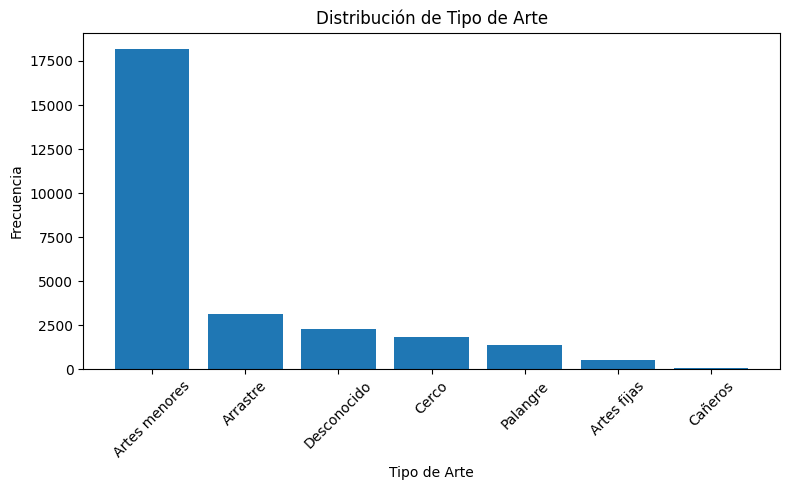

In [17]:
# Visualización del target
target = "Tipo de Arte"
conteo = data[target].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(conteo.index, conteo.values)
plt.xlabel(target)
plt.ylabel("Frecuencia")
plt.title(f"Distribución de {target}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **Normalización de las variables numéricas**
Como hemos comprobado anteriormente, las variables numéricas correspiondientes a la eslora, arqueo y porencia presenta una distribución sesgada con cola hacia la derecha, debido a la gran cantidad de buques más pequeños, mientras que la edad presenta una distribución más o menos constante con picos en diferentes intervalos de edad, por lo que esta última no se normalizará.  

Para normalizar la distribución de las variables sesgadas, se aplica una transformación logaritmica a estas variables.

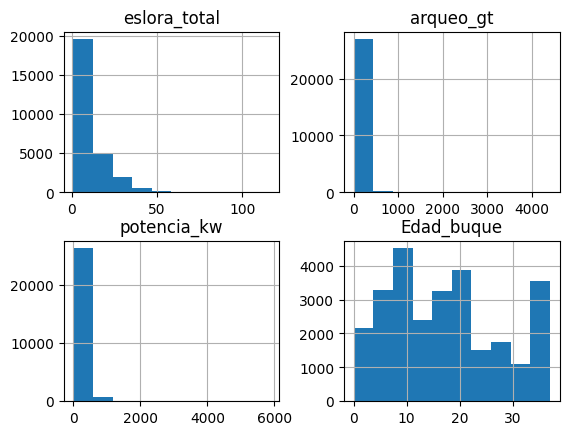

In [18]:
# Comprobar distribución de las variables numéricas
data.hist();

In [19]:
# Separación de las variables numéricas y categóricas
numeric_cols = data.select_dtypes(include=[np.number]).columns
categoric_cols = data.select_dtypes(exclude=[np.number]).drop(columns= [target, "cfr", "nombre"]).columns 


In [20]:
# Separación de los conjuntos de train y test
X = data.drop(columns=[target, "cfr", "nombre"])
y = data[target]

# Split stratificado para que se mantenga la proporción de la variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [21]:
# Normalizar las variables numéricas

normalizar = [col for col in numeric_cols if col != 'Edad_buque']
X_train[normalizar] = np.log(X_train[normalizar])
X_test[normalizar] = np.log(X_test[normalizar])

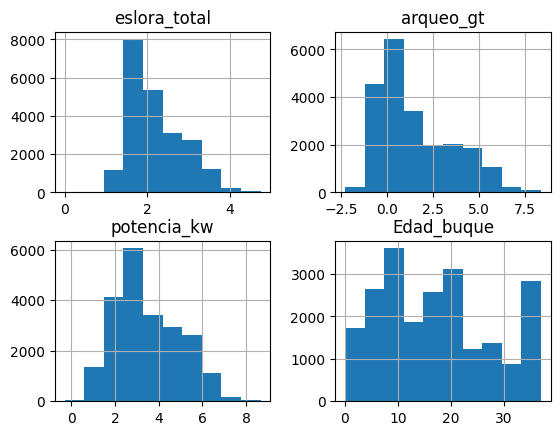

In [22]:
# Visualización de las variables numéricas normalizadas
X_train.hist();

#### **Estandarizado de las variables**
Para que la información con la que se entrena el modelo sea consistente y esté presentada en las mismas unidades, se estandarizan las variables.  

En el caso de las variables numéricas, se utiliza un Standar Scaler, que procesa las variables para que su media sea 0 y su desviación estandar 1, eliminando las unidades originales y convirtiendose en una medida relativa.  

En el caso de las variables categoricas, se utiliza el método `get_dummies` que convierte cada categoría en una nueva columna lógica (True y False).

In [23]:
# Estandarizar las variables numéricas
scaler = StandardScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [24]:
# Variables categoricas
X_train = pd.get_dummies(X_train, columns = categoric_cols)
X_test = pd.get_dummies(X_test, columns = categoric_cols)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [25]:
X_train.head()

,eslora_total,arqueo_gt,potencia_kw,Edad_buque,material_casco_-,material_casco_Acero,material_casco_Aluminio,material_casco_Fibra de Vidrio/Plástico,material_casco_Madera,material_casco_Madera forrada de Fibra,...,Comunidad Autónoma_Canarias,Comunidad Autónoma_Cantabria,Comunidad Autónoma_Cataluña,Comunidad Autónoma_Ceuta,Comunidad Autónoma_Comunitat Valenciana,Comunidad Autónoma_Galicia,Comunidad Autónoma_Illes balears,Comunidad Autónoma_Melilla,Comunidad Autónoma_Murcia,Comunidad Autónoma_País Vasco
1647,2.253812,2.350627,2.206875,-1.274535,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16661,-0.437211,-0.295791,-0.467431,0.638309,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
13,1.813216,1.684972,1.484563,-0.605039,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False
9166,1.692959,1.753181,1.757437,-1.465819,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
18564,-0.169584,-0.389223,-0.641094,-0.031186,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### **Modelado**  
Se realiza un primer modelado con 4 algoritmos de clasificación basados en bagging y boosting. Estas técnicas reducen el sesgo y error de los modelos entrenando una combinación de modelos de arboles de decisión (en paralelo en el caso del bagging o secuencialmente en el caso del boosting).  

Estos modelos se entrenaran sin optimizar para tener una primera idea de que modelo funciona mejor para este problema.  

Ya que el dataset está muy desbalanceado como hemos visto anteriormente, se tomará como métrica `balanced_accuracy` ya que toma como referencia el promedio de la sensibilidad (recall) para cada clase, de esta forma todas las clases tienen el mismo peso a la hora de evaluar.

In [26]:
models = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("LightGBM", lgb.LGBMClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(verbose=0, random_state=42))
]


for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = balanced_accuracy_score(y_test, y_pred)
    print(f"{name} balanced accuracy: {acc:.4f}")

Decision Tree balanced accuracy: 0.5940
Random Forest balanced accuracy: 0.6241
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 21891, number of used features: 254
[LightGBM] [Info] Start training from score -2.173793
[LightGBM] [Info] Start training from score -3.939392
[LightGBM] [Info] Start training from score -0.408485
[LightGBM] [Info] Start training from score -6.209641
[LightGBM] [Info] Start training from score -2.717274
[LightGBM] [Info] Start training from score -2.477398
[LightGBM] [Info] Start training from score -2.993496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM balanced accu

#### **Optimización del mejor modelo**  
El mejor modelo sin optimizar es `light_GBM` con un balanced_accuracy del 62,41%. Para optimizar sus hiperparámetros se realiza una busqueda por grid cross validation, que realiza un entrenamiento por validación cruzada para cada una de las posibles combinaciones de hiperparámetros. Tras esta optimización, el modelo queda con un f1_score de 88% y un macro accuracy del 67%, lo que supone una mejora respecto al modelo original pero con un recall bastante bajo, del 64%.

In [14]:
# Mejor modelo lightgbm
lgbm = [m for n, m in models if n == "LightGBM"][0]

# Optimización de hiperparámetros
param_grid = {
    'num_leaves': [30, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200]
}

# GridSearch con validación 3-fold
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='balanced_accuracy',  
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Entrenamiento con búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

# Mejor modelo entrenado
best_lgbm = grid_search.best_estimator_

# Predicción en test
y_pred = best_lgbm.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred,))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 21891, number of used features: 254
[LightGBM] [Info] Start training from score -2.173793
[LightGBM] [Info] Start training from score -3.939392
[LightGBM] [Info] Start training from score -0.408485
[LightGBM] [Info] Start training from score -6.209641
[LightGBM] [Info] Start training from score -2.717274
[LightGBM] [Info] Start training from score -2.477398
[LightGBM] [Info] Start training from score -2.993496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

#### **Matriz de confusión**
Observando la matriz de confusión podemos ver como los errores están distribuidos y sesgados hacia artes menores, debido al desbalanceo del conjunto de datos.

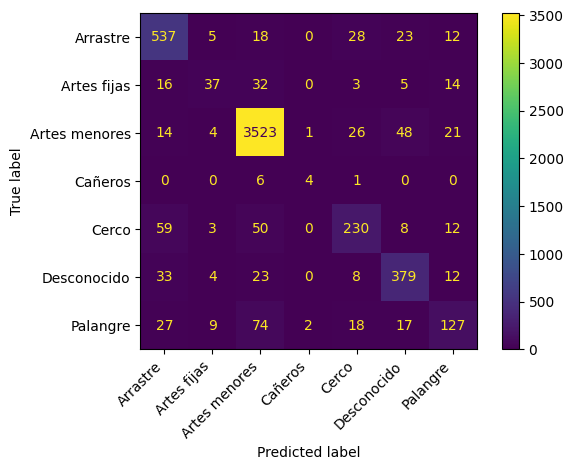

In [15]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()  
plt.show()

#### **Balanceo del dataset**
Para evitar el sesgo hacia la clase minoritaria, se realiza un resampling del dataset original utilizando `SMOTE`. A diferencia de un sobremuestreo tradicional que solamente duplica los registros de las clases minoritarias, SMOTE genera nuevos registros usando un algoritmo KNN de vecínos más cercanos, esto crea nuevos registros haciendo que las clases minoritarias estén mejor representadas.

In [16]:
# Aplicando ReSampling:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Distribución original:", Counter(y_train))
print("Distribución tras SMOTE:", Counter(y_train_resampled))

Distribución original: Counter({'Artes menores': 14550, 'Arrastre': 2490, 'Desconocido': 1838, 'Cerco': 1446, 'Palangre': 1097, 'Artes fijas': 426, 'Cañeros': 44})
Distribución tras SMOTE: Counter({'Desconocido': 14550, 'Artes menores': 14550, 'Arrastre': 14550, 'Cerco': 14550, 'Palangre': 14550, 'Artes fijas': 14550, 'Cañeros': 14550})


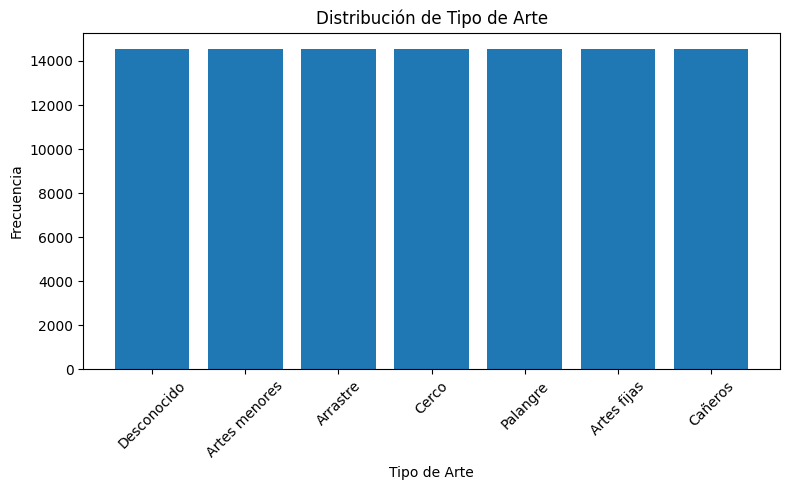

In [17]:
conteo = y_train_resampled.value_counts()

# Visualización
plt.figure(figsize=(8, 5))
plt.bar(conteo.index, conteo.values)
plt.xlabel(target)
plt.ylabel("Frecuencia")
plt.title(f"Distribución de {target}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **Modelo con sobremuestreo**
Tras realizar el sobremuestreo y entrenar el modelo obtenemos unas métricas de un recall medio del 71%, frente al 64% de recall medio del modelo sin sobremuestrear.  

Viendo el reporte de clasificación y la matriz de confusión, las clases que mejor clasifica el modelo son:
- Artes menores
- Arrastre
- Desconocido (otros)

Y las clases en las que peor funciona:
- Cañeros
- Artes Fijas 
- Palangre  

Esto se debe a que los buques que realizan estos tipos de artes de pesca son buques con características técnicas muy similares. Para mejorar estas métricas, habría que incorporar más datos, por ejemplo datos geográficos de posición, mediante los cuales se podrían obtener las trayectorias GPS de los buques, lo que ayudaría a difenrenciar mejor las técnicas de pesca.

In [ ]:
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='accuracy',  
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train_resampled, y_train_resampled)

print("Mejores hiperparámetros:", grid_search.best_params_)

best_lgbm = grid_search.best_estimator_

# Predicción en test
y_pred = best_lgbm.predict(X_test)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1594
[LightGBM] [Info] Number of data points in the train set: 101850, number of used features: 291
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [ ]:
# Reporte de clasificación
print(classification_report(y_test, y_pred,))

               precision    recall  f1-score   support

     Arrastre       0.80      0.80      0.80       623
  Artes fijas       0.50      0.52      0.51       107
Artes menores       0.96      0.95      0.95      3637
      Cañeros       0.41      0.64      0.50        11
        Cerco       0.68      0.71      0.69       362
  Desconocido       0.79      0.82      0.81       459
     Palangre       0.53      0.52      0.53       274

     accuracy                           0.87      5473
    macro avg       0.67      0.71      0.68      5473
 weighted avg       0.88      0.87      0.88      5473



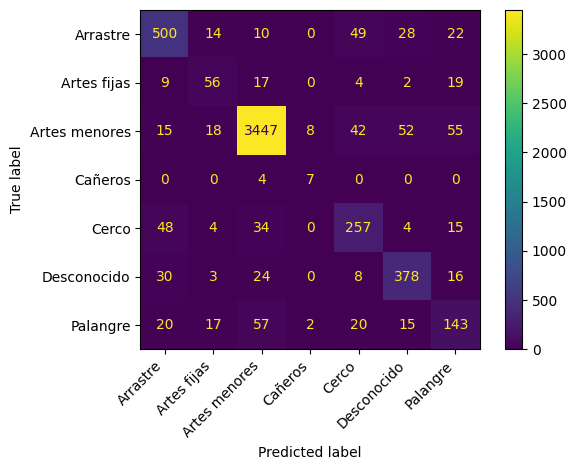

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()  
plt.show()

#### **Modelo de Deep Learning**
Realizamos un tercer modelo, esta vez de capas densas de redes neuronales.
Tras su modelado, podemos ver como las métricas son muy similares al modelo de machine learning tradicional, por lo que tomaremos como modelo final el modelo de machine learning LightGBM.

In [22]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_resampled)
y_test_enc = le.transform(y_test)

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=356, activation='relu', input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dropout(0.2)) 
model.add(keras.layers.Dense(units=264, activation='relu'))
model.add(keras.layers.Dropout(0.2)) 
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(units=len(np.unique(y_train)), activation='softmax'))

# Compilamos el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo
history = model.fit(X_train_resampled, y_train_enc, epochs=250, batch_size=364, validation_split=0.2, verbose=1, callbacks= [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)])

# Evaluamos el modelo en el set de test
test_loss, test_accuracy = model.evaluate(X_test, y_test_enc)
print(f"Accuracy en test: {test_accuracy:.4f}")

c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7208 - loss: 0.7868 - val_accuracy: 0.3067 - val_loss: 2.2731
Epoch 2/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8860 - loss: 0.3142 - val_accuracy: 0.3489 - val_loss: 1.9317
Epoch 3/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9034 - loss: 0.2694 - val_accuracy: 0.3770 - val_loss: 1.8277
Epoch 4/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9116 - loss: 0.2445 - val_accuracy: 0.3962 - val_loss: 1.6570
Epoch 5/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9195 - loss: 0.2254 - val_accuracy: 0.4621 - val_loss: 1.4239
Epoch 6/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9217 - loss: 0.2190 - val_accuracy: 0.5056 - val_loss: 1.2739
Epoch 7/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9246 - loss: 0.2067 - val_accuracy: 0.5381 - val_loss: 1.2381
Epoch 8/250
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9272 - loss: 0.1996 - val_accu

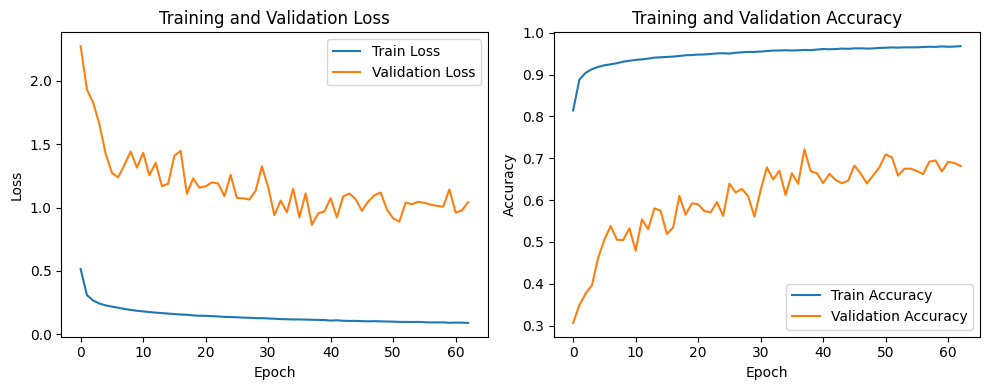

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Plot de pérdida (loss)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot de accuracy
    plt.subplot(1, 2, 2)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [25]:
y_pred_probs = model.predict(X_test)

# Elegimos la clase con mayor probabilidad
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(le.inverse_transform(y_test_enc), le.inverse_transform(y_pred)))


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
               precision    recall  f1-score   support

     Arrastre       0.78      0.82      0.80       623
  Artes fijas       0.38      0.59      0.46       107
Artes menores       0.95      0.93      0.94      3637
      Cañeros       0.43      0.55      0.48        11
        Cerco       0.66      0.70      0.68       362
  Desconocido       0.76      0.79      0.78       459
     Palangre       0.44      0.35      0.39       274

     accuracy                           0.86      5473
    macro avg       0.63      0.68      0.65      5473
 weighted avg       0.86      0.86      0.86      5473



In [26]:
# Mejor modelo lightGBM
pickle.dump(best_lgbm, open("../output/modelo_supervisado.pkl", "wb"))


### 4.1.2 Modelo no supervisado:  
El objetivo del modelado no supervisado en nuestro dataset es la agrupación de buques con características similares. Esto podría servir para optimizar recursos en cuanto a políticas pesqueras, asgnación de ayudas o detección de outliers.  
Para ello no se tendrá en cuenta el tipo de arte ni el puerto base en el que se encuentra el buque, sino sus características técnicas.


In [17]:
data_2 = data.copy()
data_2

,cfr,nombre,eslora_total,arqueo_gt,material_casco,potencia_kw,estado_rgfp,Puerto,Provincia,Comunidad Autónoma,Tipo de Arte,Edad_buque
0,ESP000000001,ARGOÑOS,19.31,52.700000,Madera,202.26,Baja Definitiva,Vicedo,Lugo,Galicia,Cerco,9
1,ESP000000002,MARIA INSOLINA,10.75,4.287333,Madera,35.30,Baja Definitiva,Santander,Cantabria,Cantabria,Artes menores,1
2,ESP000000003,MOWINKEL II,11.25,6.760000,Madera,44.13,Baja Definitiva,Ceuta,Ceuta,Ceuta,Palangre,15
3,ESP000000004,JULIA NUMERO TRES,9.15,6.622667,Madera,44.13,Baja Definitiva,Santander,Cantabria,Cantabria,Artes fijas,5
4,ESP000000005,SIEMPRE HERMANOS EZQUIAGA,19.60,40.000000,Madera,169.16,Baja Definitiva,Bermeo,Bizkaia,País Vasco,Artes menores,17
...,...,...,...,...,...,...,...,...,...,...,...,...
27359,GBR000C20512,LODAIRO,86.10,4290.000000,Acero,4000.00,Alta Definitiva,Vigo,Pontevedra,Galicia,Arrastre,6
27360,IRL000I14607,ALANNAH RILEY,28.62,374.000000,Acero,709.00,Baja Definitiva,Vigo,Pontevedra,Galicia,Arrastre,3
27361,PRT000019293,JOSE Y RAFAELA,29.46,167.000000,Acero,415.56,Alta Definitiva,Santa Pola,Alicante,Comunitat Valenciana,Artes menores,7
27362,PRT000020349,BRESO UNO,23.00,131.000000,Acero,261.03,Alta Definitiva,Burela,Lugo,Galicia,Artes fijas,8


In [ ]:
data_2 = data.copy()

# Estandarizar las variables numéricas
scaler_2 = StandardScaler()
numeric_scaled = pd.DataFrame(scaler.fit_transform(data_2[numeric_cols]), columns=numeric_cols, index=data.index)

# Codificar las variables categóricas
categoric_cols = data_2.select_dtypes(exclude=[np.number]).drop(columns= ["cfr", "nombre", "estado_rgfp", "Puerto", "Provincia", "Comunidad Autónoma"]).columns 
categoric_encoded = pd.get_dummies(data[categoric_cols])

data_preprocessed = pd.concat([numeric_scaled, categoric_encoded], axis=1)

#### **Modelado**

Para encontrar el número optimo de grupos, se realiza un entrenamiento en bucle entre 2 y 25 clusters, para buscar el punto en el que disminuye la inercia y aumenta el silhoutte score, manteniedo un número razonable de grupos diferenciados.  
Tras realizar el entrenamiento, podemos ver que aunque el silhoutte score es mayor entre 18 o 19 clusters, elegimos 11 como número de clusters final, ya que un agrupamiento en 19 grupos significaría segmentar demasiado la flota.

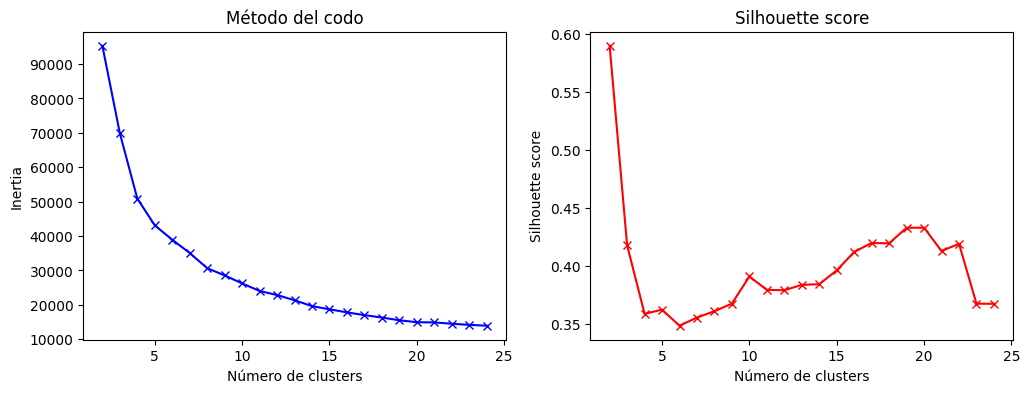

In [ ]:


inertia = []
silhouette = []

for k in range(2, 26):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(data_preprocessed)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(data_preprocessed, km.labels_))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(2,25), inertia, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.title('Método del codo')

plt.subplot(1,2,2)
plt.plot(range(2,25), silhouette, 'rx-')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score')
plt.show()

In [44]:
k = 11
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(data_preprocessed)

Representando en 2 dimensiones las agrupaciones de buques según sus clusters, podemos observar como en los valores más pequeños de sus componentes principales hay cierto solapamiento entre los grupos, pero a medida que estos valores aumentan, se forman grupos mejor definidos 

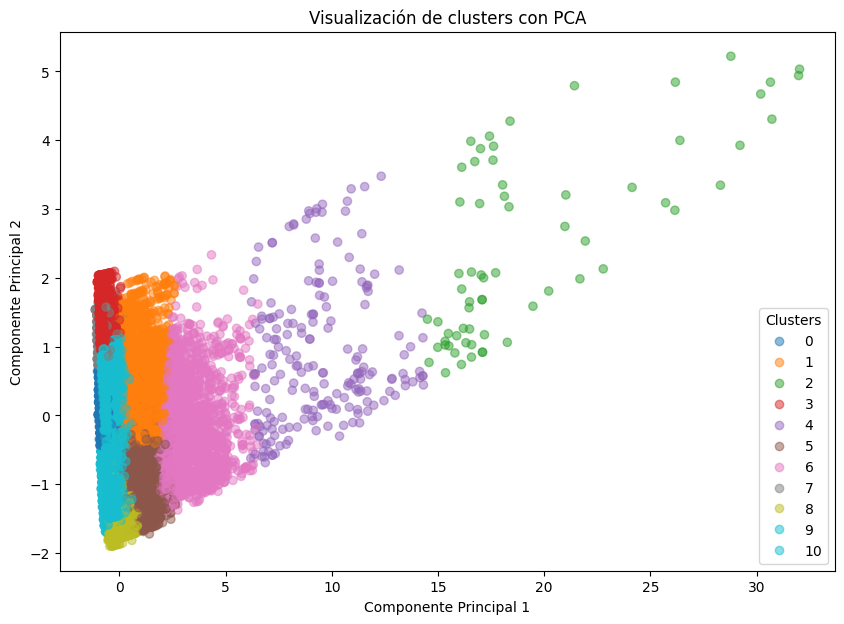

In [49]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(data_preprocessed)


pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters


plt.figure(figsize=(10,7))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap='tab10', alpha=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de clusters con PCA')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [55]:

result_df = pd.concat([data_2.reset_index(drop=True), pca_df], axis=1)

lista_cluster = range(1, 10)

result_df[['cluster'] + list(data.columns)].head()
result_df.drop(columns= ["PC1", "PC2"], inplace= True)

for i in lista_cluster:
    cluster = result_df[result_df["cluster"]==i]
    print(f"cluster: {i}: {print(cluster.head(3))}\n ----------------------------------------------------\n")


              cfr            nombre  eslora_total  arqueo_gt material_casco  \
73   ESP000000108  NUEVO ERREÑEZUBI         34.38      144.0         Madera   
89   ESP000000125         IZAR ALDE         34.20      175.0         Madera   
214  ESP000000258        YOSU ENEKO         25.20      121.0          Acero   

     potencia_kw      estado_rgfp                 Puerto   Provincia  \
73        312.59  Baja Definitiva                 Bermeo     Bizkaia   
89        588.24  Alta Definitiva  Arrecife de Lanzarote  Las Palmas   
214       294.20  Baja Definitiva                 Burela        Lugo   

    Comunidad Autónoma Tipo de Arte  Edad_buque  cluster  
73          País Vasco        Cerco          23        1  
89            Canarias      Cañeros          36        1  
214            Galicia     Arrastre          16        1  
cluster: 1: None
 ----------------------------------------------------

              cfr           nombre  eslora_total    arqueo_gt material_casco  \
613  E

In [ ]:
# Visualización del dataset resultante con su agrupación por cluster
result_df.head()

,cfr,nombre,eslora_total,arqueo_gt,material_casco,potencia_kw,estado_rgfp,Puerto,Provincia,Comunidad Autónoma,Tipo de Arte,Edad_buque,cluster
0,ESP000000001,ARGOÑOS,19.31,52.700000,Madera,202.26,Baja Definitiva,Vicedo,Lugo,Galicia,Cerco,9,5
1,ESP000000002,MARIA INSOLINA,10.75,4.287333,Madera,35.30,Baja Definitiva,Santander,Cantabria,Cantabria,Artes menores,1,10
2,ESP000000003,MOWINKEL II,11.25,6.760000,Madera,44.13,Baja Definitiva,Ceuta,Ceuta,Ceuta,Palangre,15,8
3,ESP000000004,JULIA NUMERO TRES,9.15,6.622667,Madera,44.13,Baja Definitiva,Santander,Cantabria,Cantabria,Artes fijas,5,8
4,ESP000000005,SIEMPRE HERMANOS EZQUIAGA,19.60,40.000000,Madera,169.16,Baja Definitiva,Bermeo,Bizkaia,País Vasco,Artes menores,17,5


#### **Análisis de los clusters**
Si analizamos las medias y moda de las características de los 11 clusters, podemos ver:
- Cluster 8 --> Buques muy pequeños y muy recientes, con  una eslora y potencias bajas pero con una edad < 4 años.
- Clusters 0, 3, 7, 9, 10 --> Buques pequeños con baja potencia. Eslora < 10 m y arqueo < 5 GTs, potencias < 50 KWs, predominan la madera y el poliester como material del casco.
- Clusters 3 y 7 --> Aunque también lo conforman buques pequeños, estos están más envejecidos, con una edad > 30 años.
- Clusters 1 y 5 --> Buques medianos de madera o poliester. con una eslora de alrededor de 20 m, un arqueo < 80 GTs y potencia de 210-220 KWs.
- Cluster 6 --> Buques medianos con mayor potencia, sobre los 35 m de eslora, mayor capacidad (300 GTs de arqueo) y una gran potencia, sobre los 570 KWs.
- Clusters 2 y 4 --> Buques grandes, con un tamaño de entre 60 y 80 m de media, con potencias entre 1500 y 3500 KWs y una gran capacidad de arqueo, predominando el acero como material del casco.

In [ ]:
medias_por_cluster = result_df.groupby("cluster").mean(numeric_only=True)
moda_material = result_df.groupby("cluster")["material_casco"].agg(lambda x: x.mode().iloc[0])  
medias_por_cluster["Material del casco (moda)"] = moda_material

medias_por_cluster.apply(lambda x: x.round(2))

,eslora_total,arqueo_gt,potencia_kw,Edad_buque,Material del casco (moda)
cluster,,,,,
0,6.64,2.52,21.28,18.75,Madera
1,21.49,77.21,209.27,23.16,Poliester
2,83.28,2534.71,3555.61,14.69,Acero
3,6.18,1.89,21.97,33.18,Poliester
4,59.34,1152.64,1444.77,13.72,Acero
5,19.46,63.31,216.40,10.79,Madera
6,34.16,295.97,568.47,12.15,Acero
7,8.17,4.65,31.75,33.27,Madera
8,9.27,8.79,47.64,4.29,Madera


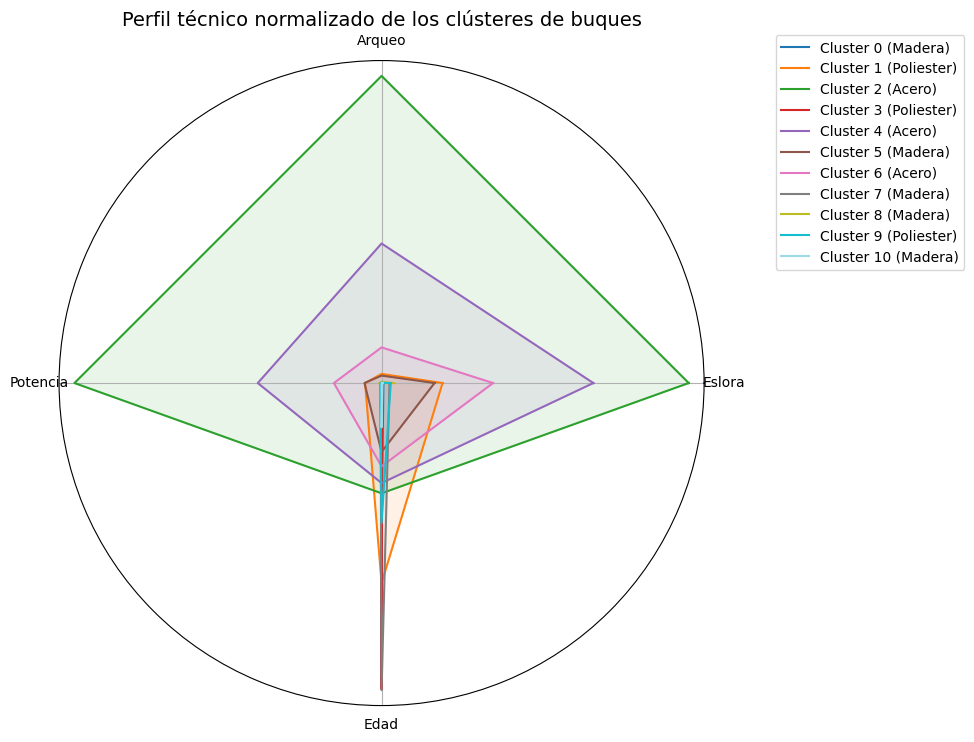

In [ ]:
# Gráfico de radar para el perfil técnico de los clusters

# Escalar las variables numéricas
scaler = MinMaxScaler()
scaled = scaler.fit_transform(medianas_por_cluster[["eslora_total", "arqueo_gt", "potencia_kw", "Edad_buque"]])
df_scaled = pd.DataFrame(scaled, columns=["Eslora", "Arqueo", "Potencia", "Edad"], index=medianas_por_cluster.index)

# Parámetros del gráfico radar
labels = df_scaled.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Crear figura
fig, ax = plt.subplots(figsize=(9, 8), subplot_kw=dict(polar=True))

# Generar una lista de colores, uno por cada clúster
colores = plt.cm.tab20(np.linspace(0, 1, len(df_scaled)))

# Dibujar cada clúster
for i, (idx, row) in enumerate(df_scaled.iterrows()):
    values = row.tolist() + [row.tolist()[0]]
    label = f"Cluster {idx} ({medianas_por_cluster.loc[idx, 'Material del casco (moda)']})"
    ax.plot(angles, values, label=label, color=colores[i])
    ax.fill(angles, values, alpha=0.1, color=colores[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks([])
ax.set_title("Perfil técnico normalizado de los clústeres de buques", size=14)
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.show()


In [ ]:
result_df.to_csv("../output/resultados_cluster.csv")

In [54]:
pickle.dump(kmeans, open("../output/modelo_no_supervisado.pkl", "wb"))

### 4.2. Aplica una prueba por contraste de hipótesis. Ten en cuenta que algunas de estas pruebas requieren verificar previamente la normalidad y homocedasticidad de los datos.

Tras realizar el modelado, aplicamos un contraste de hipóitesis para responder a las siguientes preguntas:  

- ¿Están relacionadas las comunidades autónomas con un tipo de arte en concreto?
- ¿Está el tamaño del buque (eslora) relacionada con el tipo de arte?  


#### **4.2.1 ¿Están relacionadas las comunidades autónomas con un tipo de arte en concreto?**
Ya que en el conjunto de datos predominan las embarcaciones pequeñas (aproximadamente el 90% de la flota) cuyo tipo de arte son artes menores, excluiremos este arte para el contraste de hipótesis, por lo que la pregunta a la que queremos responder pasa a ser: **Sin tener en cuenta las artes menores, ¿Existe una relación estadística significativa entre la comunidad autónoma a la que pertenece el buque, y su tipo de arte?**  

Para ello, ya que queremos comparar la distribución de la combinación de 2 variables categóricas, utilizamos el test de chi cuadrado.  
Planteamos las hipótesis nula y alternativa:  

- H0: El tipo de arte es independiente de la comunidad autónoma.
- H1: El tipo de arte depende de la comunidad autónoma.  

Tras realizar el test, con un p-value < 0.05, rechazamos la hipótesis nula y podemos afirmar con un 95% de confianza que el tipo de arte y la comunidad autónoma del buque están relacionados.

In [36]:
data_sin_artes = data[data["Tipo de Arte"] != "Artes menores"]
contingencia = pd.crosstab(data_sin_artes['Tipo de Arte'], data_sin_artes['Comunidad Autónoma'])

# Prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingencia)

print(f'Chi-cuadrado: {chi2:.4f}')
if p < 1e-16:
    print('p-valor: < 1e-16')
else:
    print(f'p-valor: {p:.4f}')

if p < 0.05:
    print("Hay asociación significativa entre el tipo de arte y la comunidad autónoma.")
else:
    print("No hay evidencia de asociación significativa entre el tipo de arte y la comunidad autónoma.")

Chi-cuadrado: 4453.4438
p-valor: < 1e-16
Hay asociación significativa entre el tipo de arte y la comunidad autónoma.


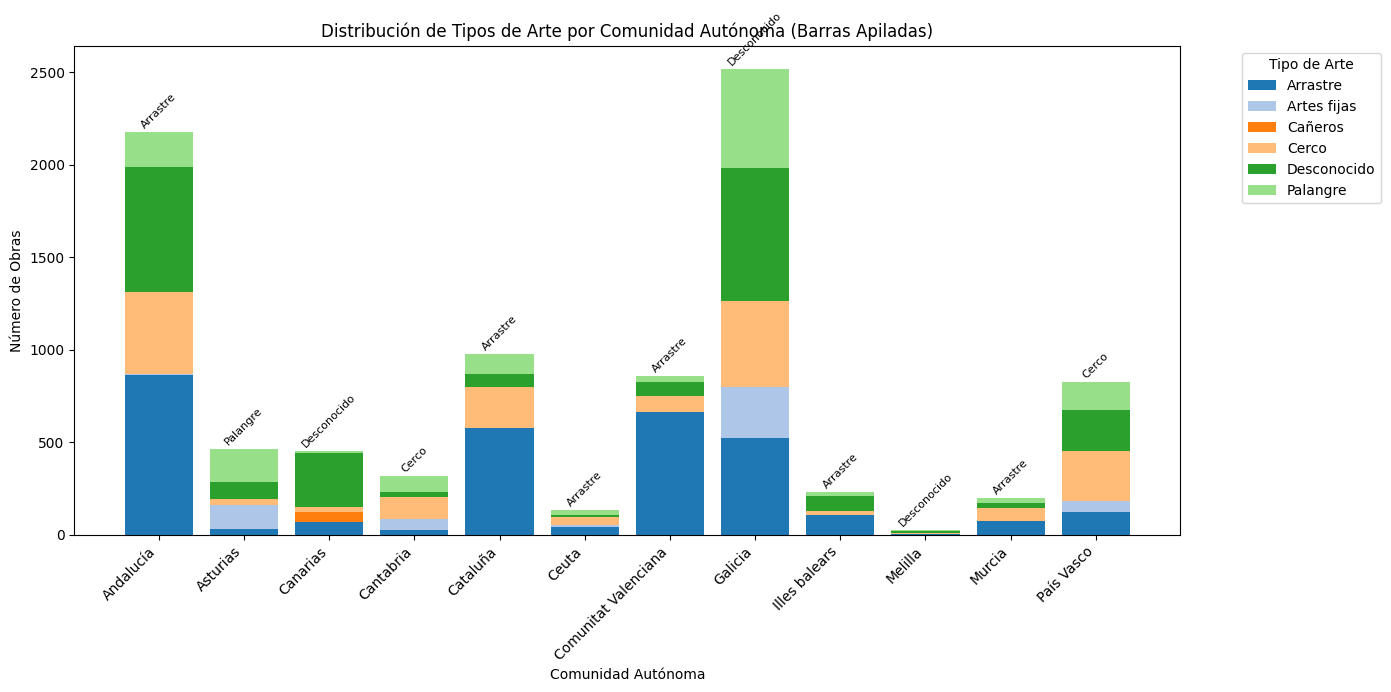

In [69]:
# Agrupar por Comunidad Autónoma y Tipo de Arte, contando las ocurrencias
conteo = data_sin_artes.groupby(['Comunidad Autónoma', 'Tipo de Arte']).size().reset_index(name='count')
pivot = conteo.pivot(index='Comunidad Autónoma', columns='Tipo de Arte', values='count').fillna(0)

# Colores
colores = plt.cm.tab20.colors
columnas = pivot.columns
colores_dict = dict(zip(columnas, colores[:len(columnas)]))

# Crear figura
plt.figure(figsize=(14, 7))

# Apilar barras
bottom = np.zeros(len(pivot))
for arte in columnas:
    plt.bar(pivot.index, pivot[arte], bottom=bottom, label=arte, color=colores_dict[arte])
    bottom += pivot[arte]

# Anotar el Tipo de Arte predominante
for idx, comunidad in enumerate(pivot.index):
    fila = pivot.loc[comunidad]
    arte_predominante = fila.idxmax()
    altura_total = fila.sum()
    plt.text(
        idx, altura_total + 10,  # un poco por encima de la barra
        arte_predominante,
        ha='center', va='bottom', fontsize=8, rotation=45
    )

# Ajustes del gráfico
plt.title('Distribución de Tipos de Arte por Comunidad Autónoma (Barras Apiladas)')
plt.xlabel('Comunidad Autónoma')
plt.ylabel('Número de Obras')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Arte', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### **4.2.2 ¿Está relacionada la eslora del buque con un tipo de arte en concreto?** 

En esta pregunta, estamos comparando una variable numérica con una variable categórica, para ello, primero tenemos que comprobar si los diferentes grupos de artes tienen varianzas iguales, es decir si tienen homoscedasticidad. Para ello utilizamos el test de Levene con un resultado de p-value < 10e-16, no se cumple la homocedasticidad por lo que no se puede utilizar un test de ANOVA, usaremos el test de Kruskal-Wallis ya que no asume normalidad ni iguldad de varianzas.  

Planteamos las hipótesis nula y alternativa: 
- H0: Todos los grupos (artes) tienen la misma distribución (eslora).  
- H1: Almenos 1 grupo tiene una distribución de eslora diferente.  

Tras realizar el test, con un p-value < 10e-16, rechazamos la hipótesis nula y afirmamos que el arte varía dependiendo de la eslora del buque.

In [71]:
grupos = [data[data['Tipo de Arte'] == tipo]['eslora_total'] for tipo in data['Tipo de Arte'].unique()]
stat, p = levene(*grupos)
print('Test de Levene (homocedasticidad):')
print('p-value: < 1e-16' if p < 1e-16 else f'p-valor: {p:.4f}')

Test de Levene (homocedasticidad):
p-value: < 1e-16


In [72]:
grupos = [grupo['eslora_total'].values for _, grupo in data.groupby('Tipo de Arte')]

# Test de Kruskal-Wallis
stat, p = kruskal(*grupos)
print('\nTest de Kruskal-Wallis:')
print('p-valor: < 1e-16' if p < 1e-16 else f'p-valor: {p:.4f}')


Test de Kruskal-Wallis:
p-valor: < 1e-16


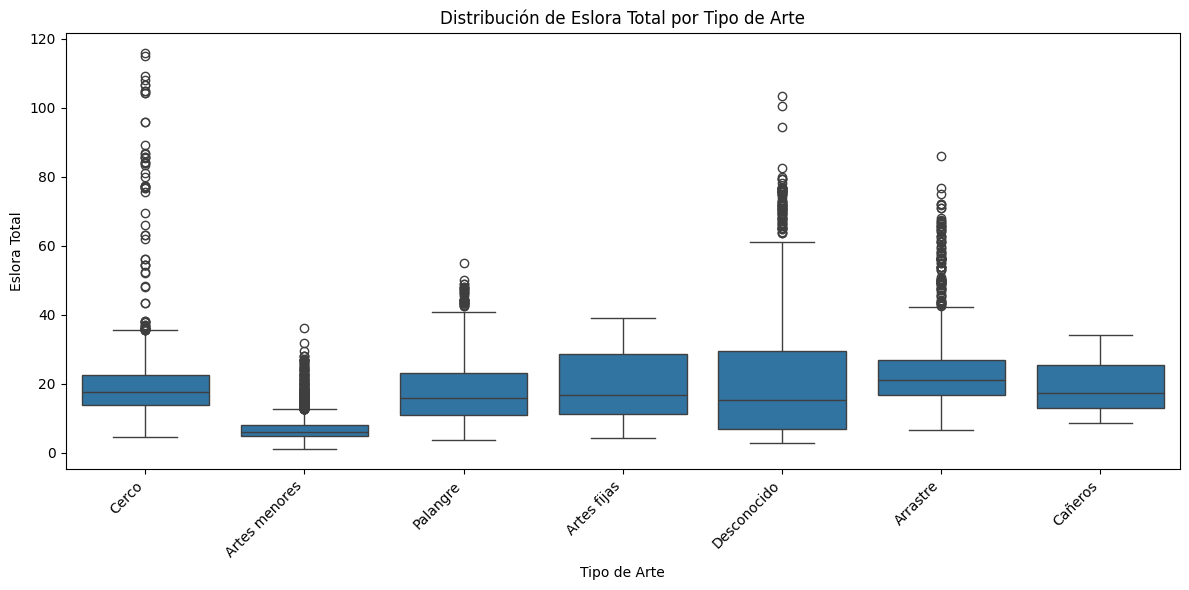

In [39]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Tipo de Arte', y='eslora_total')
plt.title('Distribución de Eslora Total por Tipo de Arte')
plt.xlabel('Tipo de Arte')
plt.ylabel('Eslora Total')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Al observar la distribución de la eslora, podemos ver como aunque las medias de eslora de los diferentes artes son similares, a excepción de artes menores que es más baja que el resto, las distribuciones son muy diferentes:  
- Cerco, desconocido y arrastre tienen los buques con las esloras más altas.
- Palangre y artes fijas presentan una distribución similar aunque palangre cuenta con buques de mayor tamaño en su distribución.
- Artes fijas y cañeros presentan la distribución más compacta sin tener outliers ninguna de las categorías.